# Environment set up

Install pyspark

In [1]:
# get spark up and running (do this once when you restart a colab session or it times out)

# first, install the jdk
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
# get spark itself
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz

# unzip spark
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
# install findspark so colab notebook sees it
!pip install -q findspark

# and setup env variable so pyspark works
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

# for using spark UI in colab... this allows tunnel to the UI
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2023-01-18 12:45:13--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.202.168.65, 18.205.222.128, 54.161.241.46, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.202.168.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13832437 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.19M  16.5MB/s    in 0.8s    

2023-01-18 12:45:14 (16.5 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13832437/13832437]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [2]:
# Now spark is installed with correct env paths.. so use findspark to install it in colab
import findspark
findspark.init()

from pyspark import SparkContext, SparkConf
# start pyspark session
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

sparkContext = spark.sparkContext
# make the spark UI work in colab

get_ipython().system_raw('./ngrok http 4050 &')
!curl -s http://localhost:4040/api/tunnels
spark

{"tunnels":[],"uri":"/api/tunnels"}


In [3]:
# imports pandas and pyspark libaries
from pyspark.sql.functions import col, isnan, when, count, mean
import pandas
# importa seaborn library for creating a heatmap
import seaborn as sea

# Task 1 - Nuclear dataset

## 1.1 Handling missing data

### Load the data

In [4]:
# load the dataset
df = spark.read.csv("nuclear_plants_small_dataset.csv", header = True,  inferSchema = True)
df.printSchema()

root
 |-- Status: string (nullable = true)
 |-- Power_range_sensor_1: double (nullable = true)
 |-- Power_range_sensor_2: double (nullable = true)
 |-- Power_range_sensor_3 : double (nullable = true)
 |-- Power_range_sensor_4: double (nullable = true)
 |-- Pressure _sensor_1: double (nullable = true)
 |-- Pressure _sensor_2: double (nullable = true)
 |-- Pressure _sensor_3: double (nullable = true)
 |-- Pressure _sensor_4: double (nullable = true)
 |-- Vibration_sensor_1: double (nullable = true)
 |-- Vibration_sensor_2: double (nullable = true)
 |-- Vibration_sensor_3: double (nullable = true)
 |-- Vibration_sensor_4: double (nullable = true)



In [5]:
df.show()

+------+--------------------+--------------------+---------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|Status|Power_range_sensor_1|Power_range_sensor_2|Power_range_sensor_3 |Power_range_sensor_4|Pressure _sensor_1|Pressure _sensor_2|Pressure _sensor_3|Pressure _sensor_4|Vibration_sensor_1|Vibration_sensor_2|Vibration_sensor_3|Vibration_sensor_4|
+------+--------------------+--------------------+---------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|Normal|              4.5044|              0.7443|                 6.34|              1.9052|           29.5315|            0.8647|            2.2044|             6.048|           14.4659|            21.648|           15.3429|            1.2186|
|Normal|        

In [6]:
# stores the total number of enrties in the dataset
totalEntries = df.count()
print(totalEntries)

996


### Find missing or incorrect data

Organising catagorical data

In [7]:
# checks for catagories with the same names that may contain error
catdf = df.groupBy("Status").count()
catdf.show()

+--------+-----+
|  Status|count|
+--------+-----+
|Abnormal|  498|
|  Normal|  498|
+--------+-----+



Find duplicates

In [8]:
import pyspark.sql.functions as f

# searches for duplicate records
dupdf = df.join(df.groupBy(df.columns).agg((f.count("*")>1).cast("int").alias("Duplicate_indicator")),on=df.columns,how="inner")

# counts duplicate records
dupes = dupdf.where(dupdf.Duplicate_indicator == "1").count()

# displays amount of duplicate records
print("There are",dupes, "duplicate rows")

There are 0 duplicate rows


Find Null values

In [9]:
# checks each coloum and counts any null values
nulldf = df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()



+------+--------------------+--------------------+---------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|Status|Power_range_sensor_1|Power_range_sensor_2|Power_range_sensor_3 |Power_range_sensor_4|Pressure _sensor_1|Pressure _sensor_2|Pressure _sensor_3|Pressure _sensor_4|Vibration_sensor_1|Vibration_sensor_2|Vibration_sensor_3|Vibration_sensor_4|
+------+--------------------+--------------------+---------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|     0|                   0|                   0|                    0|                   0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|
+------+--------

## 1.2 Summary statistics

### Split the data

In [10]:
# creates a dataframe where status is normal
normaldf = df.where(df.Status == "Normal")
normaldf.show()

+------+--------------------+--------------------+---------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|Status|Power_range_sensor_1|Power_range_sensor_2|Power_range_sensor_3 |Power_range_sensor_4|Pressure _sensor_1|Pressure _sensor_2|Pressure _sensor_3|Pressure _sensor_4|Vibration_sensor_1|Vibration_sensor_2|Vibration_sensor_3|Vibration_sensor_4|
+------+--------------------+--------------------+---------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|Normal|              4.5044|              0.7443|                 6.34|              1.9052|           29.5315|            0.8647|            2.2044|             6.048|           14.4659|            21.648|           15.3429|            1.2186|
|Normal|        

In [11]:
# creates a dataframe where status is normal
abnormaldf = df.where(df.Status == "Abnormal")
abnormaldf.show()

+--------+--------------------+--------------------+---------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|  Status|Power_range_sensor_1|Power_range_sensor_2|Power_range_sensor_3 |Power_range_sensor_4|Pressure _sensor_1|Pressure _sensor_2|Pressure _sensor_3|Pressure _sensor_4|Vibration_sensor_1|Vibration_sensor_2|Vibration_sensor_3|Vibration_sensor_4|
+--------+--------------------+--------------------+---------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|Abnormal|              8.4467|              5.8667|               9.1736|             11.6904|            1.1803|            1.4415|            4.3256|            6.4249|            8.3453|           17.5954|           14.1982|           16.2568|
|Abnorma

### Averages

In [12]:
# A function which createa a dataframe of summary statistics for each data type
def averages(DF, dataType):
  # converts the spark data frame to a pandas dataframe
  pandasDF = DF.toPandas()

  # calculates statistics
  mean = pandasDF.mean(numeric_only=True)
  median = pandasDF.median(numeric_only=True)
  min = pandasDF.min(numeric_only=True)
  max = pandasDF.max(numeric_only=True)

  # creates a new dataframe for the statistics
  group = ({'Mean': mean, "Median": median, "Max": max, "Min": min})
  final = pandas.DataFrame(group)
  final = final.reset_index(level=0)
  sparkDF = spark.createDataFrame(final.round(6))

  # displays statistics
  print("Statistics for",dataType,"Data")
  sparkDF.show()

# runs the averages function on both versions of the dataframe
averages(normaldf, "Normal")
averages(abnormaldf, "Abnormal")

  

Statistics for Normal Data
+--------------------+---------+-------+-------+------+
|               index|     Mean| Median|    Max|   Min|
+--------------------+---------+-------+-------+------+
|Power_range_sensor_1| 5.602453|5.17865|12.1298|0.0851|
|Power_range_sensor_2| 6.844503|6.71765|11.9284|0.0403|
|Power_range_senso...| 9.292054|9.26285|14.0982|4.3826|
|Power_range_sensor_4| 8.701398|9.24085|16.3568|0.1547|
|  Pressure _sensor_1|13.797526|10.6348|56.8562|0.0248|
|  Pressure _sensor_2| 3.415646|  3.113| 9.2212|0.0104|
|  Pressure _sensor_3| 5.923353| 5.7394|12.6475|0.0774|
|  Pressure _sensor_4|  5.58618|4.25915|15.1085|0.0058|
|  Vibration_sensor_1| 8.441437| 7.4499|31.4981|0.0092|
|  Vibration_sensor_2| 9.699616|8.70075|34.8676|0.0277|
|  Vibration_sensor_3|19.437804|16.4645|53.2384|0.0646|
|  Vibration_sensor_4|10.925098|9.48545|43.2314|0.0831|
+--------------------+---------+-------+-------+------+

Statistics for Abnormal Data
+--------------------+---------+--------+------

### Boxplot

In [13]:
# imports mathplot libary to create charts
import matplotlib.pyplot as plt


Boxplot function

In [14]:
# a functions which creates a collection of boxplots from a dataframe
def boxPlotter(df,tableType):

  # a counter used to keep track of columns
  counter = 0

  # sets the title of the boxplot
  title = "Boxplots for " + tableType + " Data"

  # creates lists to store column value and column names
  vals = []
  col_name = []

  # loops through each column in the dataframe
  for i in df.columns:

    # prevents a boxplot being created for the non numeric column
    if i != "Status":

      # selects the data
      values = df.select(i).collect()

      # removes the column index from the data
      values = [x.asDict()[i] for x in values]

      # adds to column data to lists
      vals.append(values)
      col_name.append(str(i))

      # increments the column counter
      counter += 1

  # creates the figure and gives it a title
  fig = plt.figure(figsize = (27,10))
  fig.suptitle(title,fontsize = 20)

  # plots data
  plt.boxplot(vals, labels=col_name)
  # displays the boxplot
  plt.show()



Boxplots

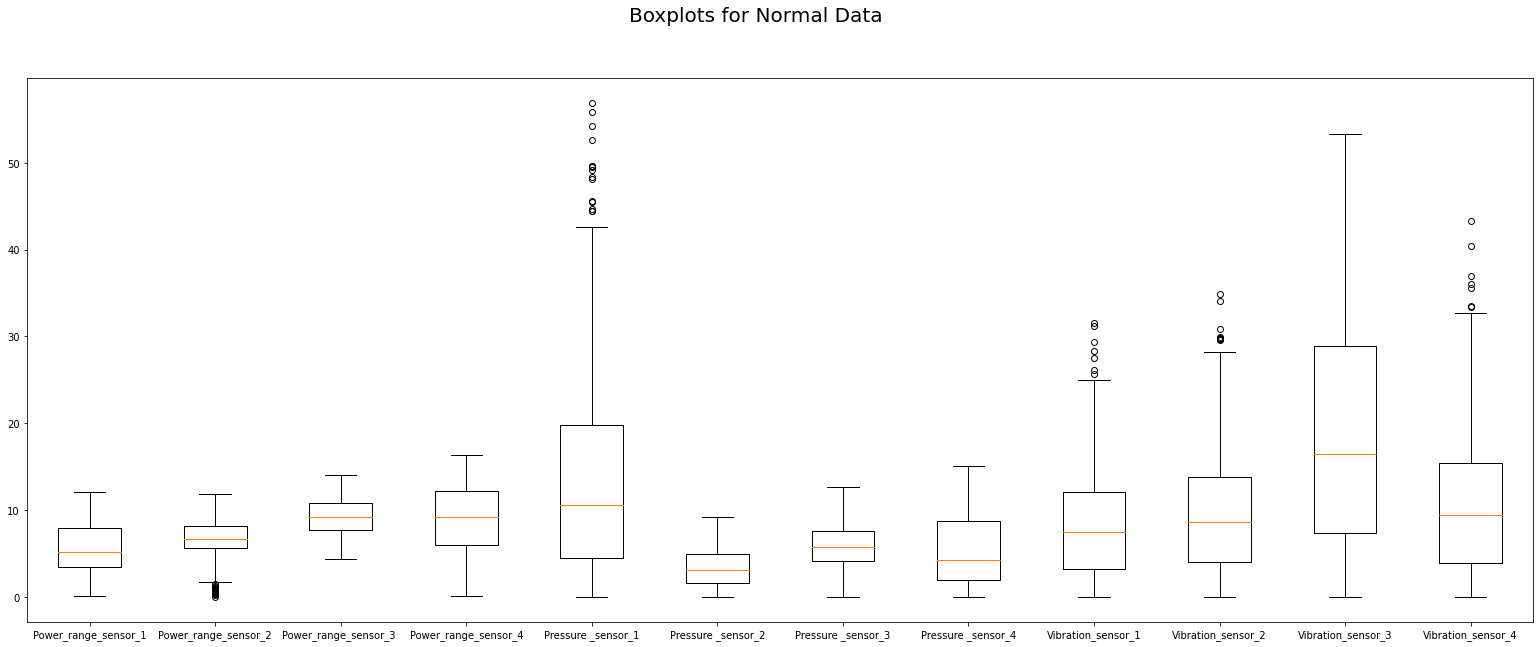

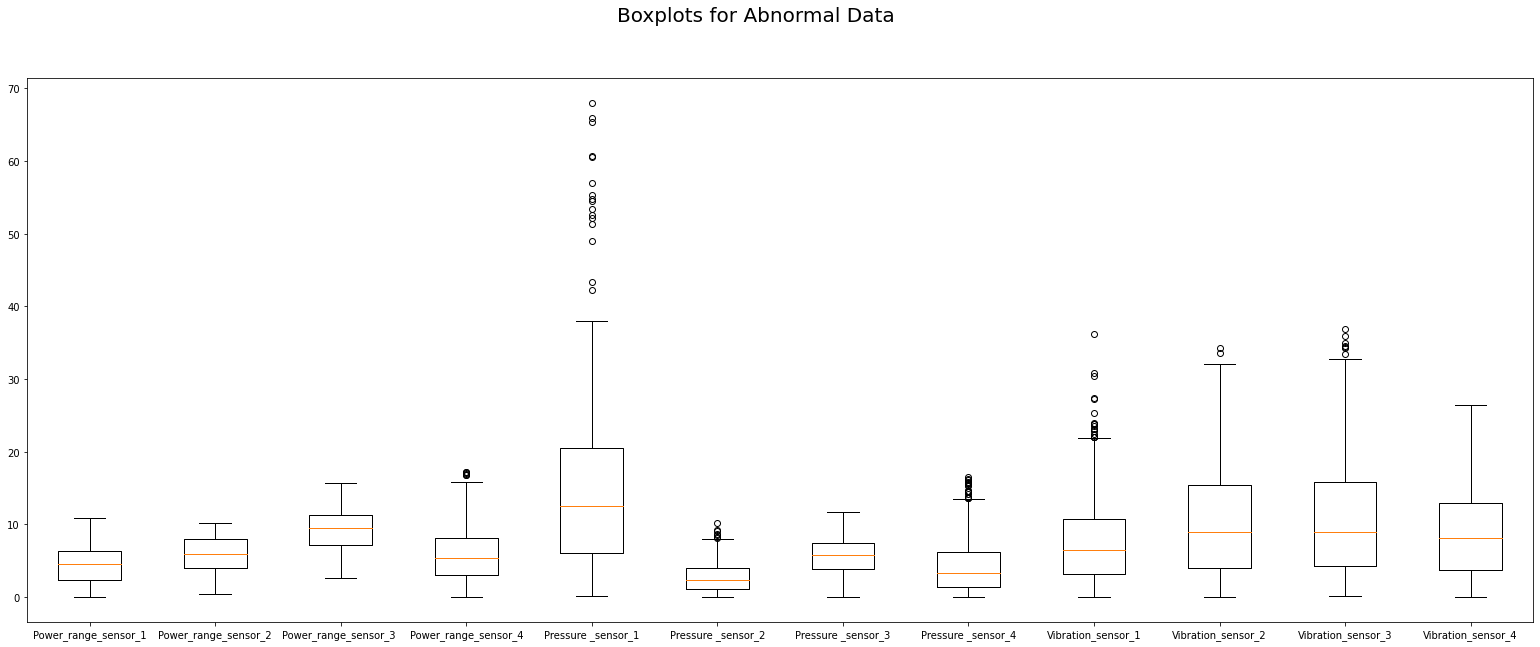

In [15]:
# creates boxplots for both normal and Abnormal data
boxPlotter(normaldf, "Normal")
boxPlotter(abnormaldf, "Abnormal")

## 1.3 Corrolation Matrix

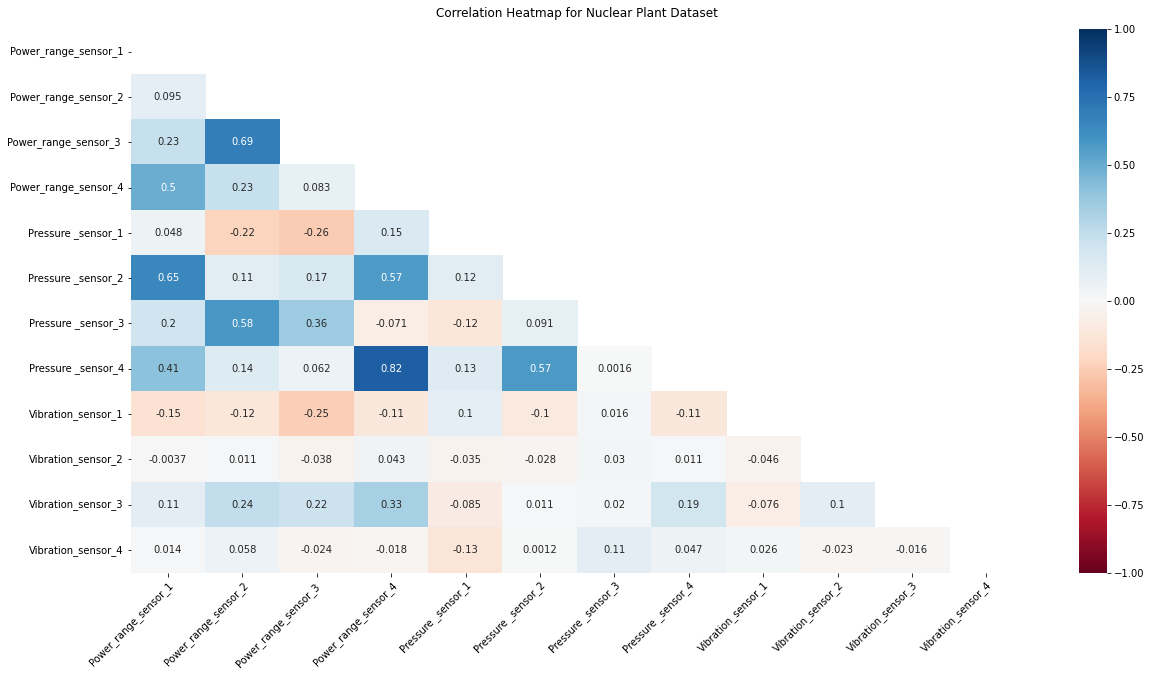

In [16]:
import numpy as np

# converts dataframe to pandas
data = df.toPandas()

# defines the size of the heatmap
plt.figure(figsize=(20, 10))

# creates a mask to stop duplicate data from appearing in the heatmap
mask = np.triu(np.ones_like(data.corr(), bool))

# creates the heatmap
heatmap = sea.heatmap(data.corr(), vmin=-1, mask=mask, vmax=1, annot=True, cmap ='RdBu')

# formats the
plt.setp(heatmap.get_xticklabels (), rotation = 45, ha = 'right', rotation_mode = 'anchor')
heatmap.set_title('Correlation Heatmap for Nuclear Plant Dataset', fontdict={'fontsize':12}, pad=12);

## 1.4 Test Train split

In [17]:
# splits the dataset 70% training 30% testing
train,test = df.randomSplit([0.7,0.3])
print("There are", train.count(), "samples in the training set")
print("There are", test.count(), "samples in the testing set")

print("")
print("Catagory split for the training set")
# counts amount of each catagory in the train set
trainSplitdf = train.groupBy("Status").count()
trainSplitdf.show()

print("Catagory split for the testing set")
# counts amount of each catagory in the test set
testSplitdf = test.groupBy("Status").count()
testSplitdf.show()

There are 726 samples in the training set
There are 270 samples in the testing set

Catagory split for the training set
+--------+-----+
|  Status|count|
+--------+-----+
|Abnormal|  370|
|  Normal|  356|
+--------+-----+

Catagory split for the testing set
+--------+-----+
|  Status|count|
+--------+-----+
|Abnormal|  128|
|  Normal|  142|
+--------+-----+



## 1.5 Machine learning

### imports and transformer decleration

In [18]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier, LinearSVC, MultilayerPerceptronClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer, VectorAssembler, OneHotEncoder, Normalizer
from pyspark.ml.linalg import Vectors
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


# converts the class lables to text to be used by the classifer
labelIndexer = StringIndexer(inputCol="Status", outputCol="label").fit(df)

# combines all the features of each row into their own vector
featureAssembler = VectorAssembler(inputCols=df.columns[1:], outputCol="features")

# encodes labels for the support vector machine
encoder = OneHotEncoder(inputCol='label', outputCol='labelVec')

### Evaluator function

In [19]:
def getStats(predictions):

    # displays a random selection of predictions
    randomPreds = predictions.sample(0.03)
    randomPreds.select("features","Status", "label", "prediction").show()

    # creates an evaluator
    eval = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

    # uses the accuracy to calculate the error rate from the accuracy
    accuracy = eval.evaluate(predictions, {eval.metricName: "accuracy"})
    print("Error Rate = %g " % (1.0 - accuracy))

    # calculates the recall score for both classes
    recall = eval.evaluate(predictions, {eval.metricName: "recallByLabel", eval.metricLabel: 1.0})
    print("recall for Normal label = %g " % (recall))
    recall = eval.evaluate(predictions, {eval.metricName: "recallByLabel", eval.metricLabel: 0.0})
    print("recall for Abnormal label = %g " % (recall))

    # calculates the sensitivity score for both classes by using the false positive rate
    fp = eval.evaluate(predictions, {eval.metricName: "falsePositiveRateByLabel", eval.metricLabel: 1.0})
    print("Specificity for Normal label = %g " % (1 - fp))
    fp = eval.evaluate(predictions, {eval.metricName: "falsePositiveRateByLabel", eval.metricLabel: 0.0})
    print("Specificity for Abnormal label= %g " % (1 - fp))

### Decicion tree


In [20]:
# creates a decision tree
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")

# creates a pipline for the machine learning model
pipeline = Pipeline(stages=[labelIndexer,encoder,featureAssembler, dt])

# fits the training data to the model
model = pipeline.fit(train)

# runs the model with the test data
predictions = model.transform(test)

print("Decision tree")

# runs a functions which returns the models performance statistics
getStats(predictions)

Decision tree
+--------------------+--------+-----+----------+
|            features|  Status|label|prediction|
+--------------------+--------+-----+----------+
|[0.74052,4.634676...|Abnormal|  0.0|       0.0|
|[1.101906,4.27788...|Abnormal|  0.0|       0.0|
|[1.483896,3.36365...|Abnormal|  0.0|       0.0|
|[3.4268,4.325,8.0...|Abnormal|  0.0|       1.0|
|[4.0897,3.9395,7....|Abnormal|  0.0|       0.0|
|[7.6089,9.1992,14...|Abnormal|  0.0|       0.0|
|[8.86584,5.042676...|Abnormal|  0.0|       0.0|
|[3.6081,8.6783,12...|  Normal|  1.0|       1.0|
|[4.5035,9.5517,13...|  Normal|  1.0|       1.0|
|[4.704,11.9284,9....|  Normal|  1.0|       1.0|
|[5.3146,5.9024,9....|  Normal|  1.0|       1.0|
+--------------------+--------+-----+----------+

Error Rate = 0.207407 
recall for Normal label = 0.838028 
recall for Abnormal label = 0.742188 
Specificity for Normal label = 0.742188 
Specificity for Abnormal label= 0.838028 


### Support Vector Machine


In [21]:
# create a support vector machine
lsvc = LinearSVC(maxIter=10, regParam=0.1)

# creates a pipline for the machine learning model
pipline = Pipeline(stages=[labelIndexer,encoder,featureAssembler,lsvc])

# fits the training data to the model
model = pipline.fit(train)

# runs the model with the test data
predictions = model.transform(test)

print("Support Vector Machine")

# runs a functions which returns the models performance statistics
getStats(predictions)

Support Vector Machine
+--------------------+--------+-----+----------+
|            features|  Status|label|prediction|
+--------------------+--------+-----+----------+
|[0.1273,8.5876,13...|Abnormal|  0.0|       0.0|
|[2.8793,8.1244,8....|Abnormal|  0.0|       1.0|
|[4.585104,5.20149...|Abnormal|  0.0|       1.0|
|[6.9223,7.8323,12...|Abnormal|  0.0|       0.0|
|[0.3983,5.5316,5....|  Normal|  1.0|       0.0|
|[1.6827,11.8625,1...|  Normal|  1.0|       0.0|
|[3.2767,7.8973,9....|  Normal|  1.0|       0.0|
|[3.5184,6.5341,7....|  Normal|  1.0|       0.0|
|[3.577,7.3379,9.4...|  Normal|  1.0|       0.0|
|[3.7949,9.2789,10...|  Normal|  1.0|       0.0|
|[5.8438,1.1902,5....|  Normal|  1.0|       1.0|
+--------------------+--------+-----+----------+

Error Rate = 0.318519 
recall for Normal label = 0.619718 
recall for Abnormal label = 0.75 
Specificity for Normal label = 0.75 
Specificity for Abnormal label= 0.619718 


### MulitLayer Perceptron

In [22]:
# defines how many layers are required along with how many nodes in each layer
layers = [12,15,15,2]

# creates a multilayer perceptrons
mlp = MultilayerPerceptronClassifier(layers=layers, seed=1)

# creates a pipline for the machine learning model
pipline = Pipeline(stages=[labelIndexer,encoder,featureAssembler,mlp])

# fits the training data to the model
model = pipline.fit(train)

# runs the model with the test data
predictions = model.transform(test)

print("Mulitlayer Perceptron")

# runs a functions which returns the models performance statistics
getStats(predictions)

Mulitlayer Perceptron
+--------------------+--------+-----+----------+
|            features|  Status|label|prediction|
+--------------------+--------+-----+----------+
|[0.6244,8.3835,9....|Abnormal|  0.0|       0.0|
|[2.049,1.2231,5.8...|Abnormal|  0.0|       0.0|
|[6.2988,8.8275,11...|Abnormal|  0.0|       0.0|
|[6.8234,7.8131,13...|Abnormal|  0.0|       0.0|
|[3.6456,7.9056,8....|  Normal|  1.0|       1.0|
|[9.3686,6.2146,11...|  Normal|  1.0|       0.0|
+--------------------+--------+-----+----------+

Error Rate = 0.225926 
recall for Normal label = 0.823944 
recall for Abnormal label = 0.71875 
Specificity for Normal label = 0.71875 
Specificity for Abnormal label= 0.823944 


# Task 2

## Imports

In [23]:
import datetime
from datetime import timedelta
import math

## Load the data


In [24]:
# creates a pandas dataframe of passenger data
cols = ['passenger_id', 'flight_id','dep_airport','dest_airport','dep_time','total_time']
passengerDF = pandas.read_csv("AComp_Passenger_data_no_error.csv", names = cols)

# creates a pandas dataframe of airport data
cols = ['airport_name','code','lat','long']
airportDF = pandas.read_csv("Top30_airports_LatLong.csv", names = cols)

# displays both dataframes
display(passengerDF)
display(airportDF)

,passenger_id,flight_id,dep_airport,dest_airport,dep_time,total_time
0,UES9151GS5,SQU6245R,DEN,FRA,1420564460,1049
1,UES9151GS5,XXQ4064B,JFK,FRA,1420563917,802
2,EZC9678QI6,SOH3431A,ORD,MIA,1420563649,250
3,ONL0812DH1,SOH3431A,ORD,MIA,1420563649,250
4,CYJ0225CH1,PME8178S,DEN,PEK,1420564409,1322
...,...,...,...,...,...,...
495,BWI0520BG6,BER7172M,KUL,LAS,1420565167,1848
496,LLZ3798PE3,EWH6301Y,CAN,DFW,1420564967,1683
497,KKP5277HZ7,KJR6646J,IAH,BKK,1420565203,1928
498,JJM4724RF7,XXQ4064B,JFK,FRA,1420563917,802


,airport_name,code,lat,long
0,ATLANTA,ATL,33.636719,-84.428067
1,BEIJING,PEK,40.080111,116.584556
2,LONDON,LHR,51.477500,-0.461389
3,CHICAGO,ORD,41.978603,-87.904842
4,TOKYO,HND,35.552258,139.779694
5,LOS ANGELES,LAX,33.942536,-118.408075
6,PARIS,CDG,49.012779,2.550000
7,DALLAS/FORT WORTH,DFW,32.896828,-97.037997
8,FRANKFURT,FRA,50.026421,8.543125
9,HONG KONG,HKG,22.308919,113.914603


## 2.1 Determine Number of Flights


### Creating an RDD

In [73]:
# converts the pandas dataframe to a spark dataframe
spark_Passengers = spark.createDataFrame(passengerDF)

# coverts spark to rdd
rdd_Passengers = spark_Passengers.rdd

# parallelizes the rdd
dist_PassengersDF = sparkContext.parallelize(rdd_Passengers.collect(),10)

### Mapping function


In [74]:
# a function which counts deparetures
def getName(x):

  # stores the flights id and departing airport
  flight_ID = x.__getitem__('flight_id')
  dep = x.__getitem__('dep_airport')

  # store information about airport
  row = airportDF[airportDF['code'].str.contains(dep)]
  
  # returns flight IDs paired with airport name
  return (flight_ID,row['airport_name'].iloc[0])

### MapReduce

In [82]:
from collections import Counter

# maps departing airports to flight IDs
mapped_flights = dist_PassengersDF.map(getName)

# reduces mapped output get a list of unique flights
reduced_flights = mapped_flights.reduceByKey(lambda x,y : x).collect()

# creates a list of airports from list of flights
airports_list = []
for i in reduced_flights:
  airports_list.append(i[1])

# counts occurence of each airport
num_flights = Counter(airports_list)

# outputs a list of unique airports
for key,value in num_flights.items():
  print("Airport: {}, Flights: {}".format(key,value))


# stores unused airports
not_used = []

# loops through list of airports
for index, row in airportDF.iterrows():
  # checks if airport is in list of used airports
  if any(row[0] in sublist for sublist in reduced_flights) == False:
    not_used.append(row[0])

# prints unused airports in vertical list
print("\nAirports with no departures")
for i in range(len(not_used)):
  print(not_used[i])

Airport: NEW YORK, Flights: 1
Airport: TOKYO, Flights: 1
Airport: DENVER, Flights: 3
Airport: MUNICH, Flights: 1
Airport: DALLAS/FORT WORTH, Flights: 1
Airport: GUANGZHOU, Flights: 2
Airport: HOUSTON, Flights: 2
Airport: BANGKOK, Flights: 1
Airport: MADRID, Flights: 1
Airport: JAKARTA, Flights: 2
Airport: CHARLOTTE, Flights: 1
Airport: ATLANTA, Flights: 2
Airport: PARIS, Flights: 1
Airport: KUALA LUMPUR, Flights: 2
Airport: SHANGHAI, Flights: 1
Airport: ROME, Flights: 1
Airport: LONDON, Flights: 1
Airport: MIAMI, Flights: 1
Airport: CHICAGO, Flights: 2
Airport: LAS VEGAS, Flights: 1
Airport: BEIJING, Flights: 1
Airport: AMSTERDAM, Flights: 1

Airports with no departures
LOS ANGELES
FRANKFURT
HONG KONG
DUBAI
SINGAPORE
SAN FRANCISCO
PHOENIX
ISTANBUL


## 2.2 Flight List

### Mapping functions


In [76]:
# A functiom which stores flight information for each passenger
def getFlight (x):

  # gets the departure information
  dep = x.__getitem__('dep_airport')
  dep_time = datetime.datetime.fromtimestamp(x.__getitem__('dep_time'))

  # get the arrival information
  arrive = x.__getitem__('dest_airport')
  arrive_time = dep_time + timedelta(minutes = x.__getitem__('total_time'))

  return (str(x.__getitem__('flight_id')), 1, dep, arrive, str(dep_time), str(arrive_time))

### Reduce functions

In [77]:
# a function handle tuples of flight information
def reducer(x,y):

  # converts tuple inputs to lists for indexing
  y = list(y)
  if type(x) != list:
    x = [list(x)]

  # checks for parrellised lists of lists
  if type(y[0]) == list:

    # loops through each individual flight record
    for i in y:
      # adds record to the list of flights
      x = joiner(x,i)
    return x

  else:
    # adds record to the list of flights
    x = joiner(x,y)
    return x


# a function which gets the index for a flight
def find_element(x, lst):
    res = [(i, row.index(x)) for i, row in enumerate(lst) if x in row]
    return res[0]

# a function which combines flight information
def joiner(x,y):
  # checks if the current flight information if stored in the previous list
  if any(y[0] in sublist for sublist in x):

    # finds the index of the flight data
    pos = find_element(y[0], x)

    # increments number of passengers
    x[pos[0]][1] = x[pos[0]][1] + y[1]
    return x

  else:
    # adds new flight data to list
    x.append(y)

  return x


### MapReduce

In [78]:
# maps flight IDs to flight information
mapped_IDs = dist_PassengersDF.map(getFlight)

# reduces mapped output to calculate amount of passengers on each flight
reduced_IDs = mapped_IDs.reduce(reducer)


# prints list of flight information
for i in reduced_IDs:
  print("Flight Code: {}, Passengers: {}, Departing: {} - {}, Destination: {} - {}".format(i[0], i[1], i[2], i[4], i[3], i[5]))

Flight Code: SQU6245R, Passengers: 21, Departing: DEN - 2015-01-06 17:14:20, Destination: FRA - 2015-01-07 10:43:20
Flight Code: XXQ4064B, Passengers: 25, Departing: JFK - 2015-01-06 17:05:17, Destination: FRA - 2015-01-07 06:27:17
Flight Code: SOH3431A, Passengers: 18, Departing: ORD - 2015-01-06 17:00:49, Destination: MIA - 2015-01-06 21:10:49
Flight Code: PME8178S, Passengers: 18, Departing: DEN - 2015-01-06 17:13:29, Destination: PEK - 2015-01-07 15:15:29
Flight Code: MBA8071P, Passengers: 16, Departing: KUL - 2015-01-06 17:04:16, Destination: PEK - 2015-01-07 02:36:16
Flight Code: MOO1786A, Passengers: 13, Departing: MAD - 2015-01-06 16:56:48, Destination: FRA - 2015-01-06 20:00:48
Flight Code: HUR0974O, Passengers: 7, Departing: DEN - 2015-01-06 17:15:25, Destination: PVG - 2015-01-07 16:33:25
Flight Code: GMO5938W, Passengers: 25, Departing: LHR - 2015-01-06 17:11:57, Destination: PEK - 2015-01-07 10:48:57
Flight Code: DAU2617A, Passengers: 12, Departing: CGK - 2015-01-06 17:23:

## 2.3 Air Miles


### Map Function

In [85]:
# a function which maps the passenger ID to the nautical miles of a flight
def getMiles(x):

  # gets the passengers id and relavant IATA/FAA codes
  pass_ID = x.__getitem__('passenger_id')
  dep = x.__getitem__('dep_airport')
  dest = x.__getitem__('dest_airport')

  # gets the coordinates for each airport
  dep_lat,dep_lon = getCoords(dep)
  dest_lat,dest_lon = getCoords(dest)

  # calcualtes distance between airports in miles
  miles = haversine(dep_lat,dep_lon,dest_lat,dest_lon)
  return(pass_ID, miles)

# a function which returns the location of an airport
def getCoords(code):
  # fetches airports location
  row = airportDF[airportDF['code'].str.contains(code)]
  lat = row['lat'].iloc[0]
  lon = row['long'].iloc[0]
  return lat, lon


######################################################
# This function was taken from an external souce which can be found at the link below:
# https://www.geeksforgeeks.org/haversine-formula-to-find-distance-between-two-points-on-a-sphere/

# a function used to calculate the distance betweeen two locations
def haversine(lat1, lon1, lat2, lon2):
     
  # distance between latitudes
  # and longitudes
  dLat = (lat2 - lat1) * math.pi / 180.0
  dLon = (lon2 - lon1) * math.pi / 180.0
 
  # convert to radians
  lat1 = (lat1) * math.pi / 180.0
  lat2 = (lat2) * math.pi / 180.0
 
  # apply formulae
  a = (pow(math.sin(dLat / 2), 2) + pow(math.sin(dLon / 2), 2) * math.cos(lat1) * math.cos(lat2))
  rad = 6371
  c = 2 * math.asin(math.sqrt(a))
  return (rad * c) * 0.621371

### MapReduce

In [87]:
# maps passengers to miles per each flight
mapped_miles = dist_PassengersDF.map(getMiles)

# reduces mapped output to calculate amount of miles per passenger
reduced_miles = mapped_miles.reduceByKey(lambda x,y : x+y).collect()

# sorts output by passengers with the highest miles
reduced_miles.sort(reverse=True,key = lambda x: x[1])

# prints used airports in a vertical list
print("Passenger Air Miles:")
for i in range(len(reduced_miles)):
  print("PassengerID: {}, Nautical Miles: {}".format(reduced_miles[i][0],reduced_miles[i][1]))

Passenger Air Miles:
PassengerID: UES9151GS5, Nautical Miles: 151763.18251262573
PassengerID: BWI0520BG6, Nautical Miles: 143545.01442597815
PassengerID: DAZ3029XA0, Nautical Miles: 141641.24645366738
PassengerID: SPR4484HA6, Nautical Miles: 140692.05553430595
PassengerID: PUD8209OG3, Nautical Miles: 133274.7719109132
PassengerID: WBE6935NU3, Nautical Miles: 114110.39602287057
PassengerID: HCA3158QA6, Nautical Miles: 111618.2004400387
PassengerID: WYU2010YH8, Nautical Miles: 111321.60008596993
PassengerID: JJM4724RF7, Nautical Miles: 107071.54069130117
PassengerID: CKZ3132BR4, Nautical Miles: 106710.11756484494
PassengerID: EZC9678QI6, Nautical Miles: 102787.08230615372
PassengerID: LLZ3798PE3, Nautical Miles: 96775.99542169354
PassengerID: HGO4350KK1, Nautical Miles: 94129.12215077925
PassengerID: POP2875LH3, Nautical Miles: 93249.46713381329
PassengerID: CXN7304ER2, Nautical Miles: 90617.10661535157
PassengerID: YMH6360YP0, Nautical Miles: 87755.92057701477
PassengerID: VZY2993ME1, N